In [158]:
!pip install numpy
!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

In [159]:
class Params:
    """Params hold a set of hyper parameters relevant to a simulation experiment

    Attributes:
        total_steps (int): The total number of steps per trial.
        btc_price_drift (float): BTC Monte Carlo GBM price drift.
        btc_price_volatility (float): BTC Monte Carlo GBM price volatility.
        su_demand_drift (float): SU Monte Carlo GBM demand drift.
        su_demand_volatility (float): SU Monte Carlo std demand volatility.
        initial_reserve_ratio (float): The ratio initial between Bitcoin and
            Stable units.
        target_reserve_ratio (float): The reserve ratio targeted by the contract
        initial_btc_reserve (float): Initial Bitcoin reserve size.
        initial_btc_price (float): Initial Bitcoin price per unit.
        lowest_ask (float): The contract spread above 1 dollar.
        highest_bid (float): The contract spread bellow 1 dollar.
    """
    def __init__(self):
        self.total_steps = FLAGS_total_steps
        self.total_trials = FLAGS_total_trials
        self.delta_t = FLAGS_delta_t
        self.btc_price_drift = FLAGS_btc_price_drift
        self.btc_price_volatility = FLAGS_btc_price_volatility
        self.su_demand_drift = FLAGS_su_demand_drift
        self.su_demand_volatility = FLAGS_su_demand_volatility
        self.initial_reserve_ratio = FLAGS_initial_reserve_ratio
        self.target_reserve_ratio = FLAGS_target_reserve_ratio
        self.initial_btc_reserve  = FLAGS_initial_btc_reserve
        self.initial_btc_price  = FLAGS_initial_btc_price
        self.lowest_ask = FLAGS_lowest_ask
        self.highest_bid = FLAGS_highest_bid
        self.do_rebase = FLAGS_do_rebase
        self.print_step = FLAGS_print_step

    def __str__(self):
        return (' total steps: ' + "%0.2f" % self.total_steps + '\n' + \
                ' total trials: ' + "%0.2f" % self.total_trials + '\n' + \
    ' delta t: ' + "%0.4f" % self.delta_t + '\n' + \
    ' btc price drift: ' + "%0.4f" % self.btc_price_drift + '\n' + \
    ' btc price volatility: ' + "%0.4f" % self.btc_price_volatility + '\n' + \
    ' su demand drift: ' + "%0.4f" % self.su_demand_drift + '\n' + \
    ' su demand volatility: ' + "%0.4f" % self.su_demand_volatility + '\n' + \
    ' initial reserve ratio: '+"%0.4f" % self.initial_reserve_ratio + '\n' + \
    ' initial btc reserve: ' + "%0.4f" % self.initial_btc_reserve + '\n' + \
    ' initial btc price: ' + "%0.4f" % self.initial_btc_price + '\n' + \
    ' lowest ask: ' + "%0.3f" % self.lowest_ask + '\n' + \
    ' highest bid: ' + "%0.3f" % self.highest_bid + '\n' + \
    ' do rebase: ' + str(self.do_rebase) + '\n' + \
    ' print step: ' + str(self.print_step))


class State:
    """State holds the current and historical values associated with a trial.

    Attributes:
        steps (list[int]): Step number index.
        btc_reserve (list[float]): Total BTC in reserve at each step.
        btc_prices (list[float]): USD per unit BTC per step.
        btc_reserve_value (list[float]): US dollar value of BTC reserve.
        reserve_ratio (list[float]): BTC reserve value over SU.
        su_cumulative_demand (list[float]): Cumulative density of Stable unit
            demand at each step.
        su_circulation (list[float]): Total SU in circulation per step.
    """
    def __init__(self, params):
        """ Args:
                params (Class): object carrying hyperparams for experiment.
        """
        self.steps = [0]
        self.btc_reserve = [params.initial_btc_reserve]
        self.btc_prices =  [params.initial_btc_price]
        self.btc_reserve_value = \
            [params.initial_btc_reserve * params.initial_btc_price]
        self.reserve_ratio = [params.initial_reserve_ratio]
        self.su_cumulative_demand = [0.0]
        self.su_circulation = [params.initial_btc_reserve * \
                params.initial_btc_price * 1 / params.initial_reserve_ratio]

    def __str__(self):
        return 'step ' + "%0.0f" % self.steps[-1] +\
               ' su_total ' + "%0.2f" % self.su_circulation[-1] + \
               ' btc_total ' + "%0.4f" % self.btc_reserve[-1] + \
               ' btc_price ' + "%0.4f" % self.btc_prices[-1] + \
               ' btc_value ' + "%0.4f" % self.btc_reserve_value[-1] + \
               ' reserve_ratio ' + "%0.4f" % self.reserve_ratio[-1]


In [160]:
def do_step(params, state):
    """ Performs a single Monte Carlo Step simulating the state of the contract.
        Args:
            params (Class): Object containing the contract hyperparameters.
            state (Class): Object containing the contract's current state.
    """
    # Produce a Bitcoin price delta using Geometric Brownian motion (GBM).
    btc_price_delta = state.btc_prices[-1] * \
        (params.btc_price_drift * params.delta_t + \
         params.btc_price_volatility * math.sqrt(params.delta_t) * \
         np.random.standard_normal())

    # Next Bitcoin price.
    btc_price = state.btc_prices[-1] + btc_price_delta

    # Produce a Stable Unit demand delta using GBM.
    su_demand_delta = state.su_circulation[-1] * \
            (params.su_demand_drift * params.delta_t + \
             params.su_demand_volatility * math.sqrt(params.delta_t) * \
             np.random.standard_normal())

    # Update the Stable Unit CDF
    su_cumulative_demand = state.su_cumulative_demand[-1] + su_demand_delta

    # At each step we model the change in SU circulation with respect to the
    # change in demand.
    circulation_delta = su_demand_delta

    # Below: Simulate the contract buy-sell behavior outside the spread.
    # SUs are being minted from the smart contract in exchange for Bitcoin.
    if circulation_delta >= 0:
        # SU circulation is expanded with demand.
        su_circulation_delta = circulation_delta

        # The bitcoin reserve is credited with the new sale of stable units.
        btc_reserve_delta = (1 /state.btc_prices[-1]) * circulation_delta * \
                (params.lowest_ask)

    # SUs are being sold to the contract in exchange for Bitcoin.
    else:
        # SU circulation is decreased in response to a loss of demand.
        su_circulation_delta = circulation_delta

        # The contracts reserve is depleted as it buys back stable units.
        btc_reserve_delta =  su_circulation_delta * \
                (1 / state.btc_prices[-1]) * params.highest_bid

    # Updated State Params.
    su_circulation = state.su_circulation[-1] + su_circulation_delta
    btc_reserve = state.btc_reserve[-1] + btc_reserve_delta
    btc_reserve_value = btc_reserve * btc_price
    reserve_ratio = btc_reserve_value / su_circulation

    # If the target reserve ratio pushes above the target. The contract rebases
    # the ratio of Stable Units by splitting units and increasing supply.
    su_rebase_delta = 0
    if params.do_rebase:
        off_factor = (reserve_ratio-params.target_reserve_ratio) / reserve_ratio
        if off_factor > 0:
            su_rebase_delta = su_circulation * (1 + off_factor) - su_circulation
            su_circulation = su_circulation + su_rebase_delta

    # Update the  State.
    state.su_circulation.append(su_circulation)
    state.su_cumulative_demand.append(su_cumulative_demand)
    state.btc_prices.append(btc_price)
    state.btc_reserve.append(btc_reserve)
    state.btc_reserve_value.append(btc_reserve_value)
    state.reserve_ratio.append(reserve_ratio)
    state.steps.append(state.steps[-1] + 1)

    if params.print_step:
        print(  'step', "%0.0f" % state.steps[-1], \
                'su_total', "%0.2f" % su_circulation, \
                'su_demand_delta',"%0.4f" % su_demand_delta, \
                'su_circulation_delta' , "%0.2f" % circulation_delta, \
                'su_delta', "%0.2f" % su_circulation_delta, \
                'su_rebase_delta', "%0.2f" % su_rebase_delta, \
                'btc_total', "%0.4f" % btc_reserve, \
                'btc_price', "%0.4f" % btc_price, \
                'btc_price_delta', "%0.4f" % btc_price_delta, \
                'btc_delta', "%0.4f" % btc_reserve_delta, \
                'btc_value', "%0.4f" % btc_reserve_value, \
                'reserve_ratio', "%0.4f" % reserve_ratio)


    return state

In [161]:
def plot_bitcoin_price(results):
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_btc_price = []
    for state in results:
        final_btc_price.append(state.btc_prices[-1])
        ax1.plot(state.btc_prices)
    final_btc_price = np.asarray(final_btc_price)

    ax1.set_title('Bitcoin Price (BTC/USD)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('price (USD)', fontsize=14)

    n, bins, patches = ax2.hist(final_btc_price, bins=int(math.sqrt(len(results))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_btc_price.mean(), color='r', linestyle='dashed', label='mean', linewidth=2)
    ax2.axhline(np.median(final_btc_price), color='b', linestyle='dashed', label='median', linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(results)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.legend()

    plt.show()

def plot_su_cum_demand(results):
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_su_demand = []
    for state in results:
        final_su_demand.append(state.su_cumulative_demand[-1])
        ax1.plot(state.su_cumulative_demand)
    final_su_demand = np.asarray(final_su_demand)

    ax1.set_title('Cumulative Demand (SU)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('Cumulative Demand (SU)', fontsize=14)

    n, bins, patches = ax2.hist(final_su_demand, bins=int(math.sqrt(len(results))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_su_demand.mean(), color='r', linestyle='dashed', label='mean', linewidth=2)
    ax2.axhline(np.median(final_su_demand), color='b', linestyle='dashed', label='median', linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(results)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.legend()

    plt.show()
    
def plot_reserve_ratio(results):
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_reserve_ratio = []
    for state in results:
        final_reserve_ratio.append(state.reserve_ratio[-1])
        ax1.plot(state.reserve_ratio)
    final_reserve_ratio = np.asarray(final_reserve_ratio)

    ax1.set_title('Reserve Ratio (Reserve Value/Market Cap)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('Reserve Ratio (%)', fontsize=14)

    n, bins, patches = ax2.hist(final_reserve_ratio, bins=int(math.sqrt(len(results))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_reserve_ratio.mean(), color='r', linestyle='dashed', label='mean', linewidth=2)
    ax2.axhline(np.median(final_reserve_ratio), color='b', linestyle='dashed', label='median', linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(results)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.legend()

    plt.show()
    
def plot_circulation(results):
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_su_circulation = []
    for state in results:
        final_su_circulation.append(state.su_circulation[-1])
        ax1.plot(state.su_circulation)
    final_su_circulation = np.asarray(final_su_circulation)

    ax1.set_title('Stable Unit Circulation (SU)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('Circulation (SU)', fontsize=14)

    n, bins, patches = ax2.hist(final_su_circulation, bins=int(math.sqrt(len(results))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_su_circulation.mean(), color='r', linestyle='dashed', label='mean', linewidth=2)
    ax2.axhline(np.median(final_su_circulation), color='b', linestyle='dashed', label='median', linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(results)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.legend()

    plt.show()

In [162]:
def should_end_trial(params, state):
    if (state.btc_reserve[-1] < 0):
        return True
    elif (state.su_circulation[-1] < 0):
        return True
    elif (state.steps[-1] >= params.total_steps):
        return True
    else:
        return False

def run_trial(params):
    state = State(params)
    while not should_end_trial(params, state):
        state = do_step(params, state)
    return state

def run_experiment(params):
    results = []
    for trial in range(0, params.total_trials):
        results.append(run_trial(params))
    return results


Experiment Params:  total steps: 1000.00
 total trials: 1000.00
 delta t: 1.0000
 btc price drift: 0.0000
 btc price volatility: 0.0010
 su demand drift: 0.0000
 su demand volatility: 0.0010
 initial reserve ratio: 1.0000
 initial btc reserve: 100.0000
 initial btc price: 8000.0000
 lowest ask: 1.010
 highest bid: 0.990
 do rebase: True
 print step: False


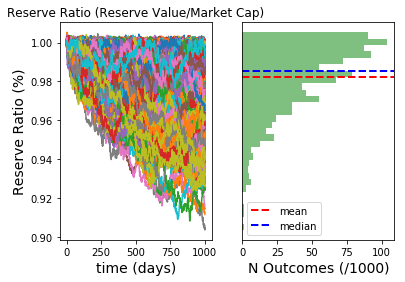

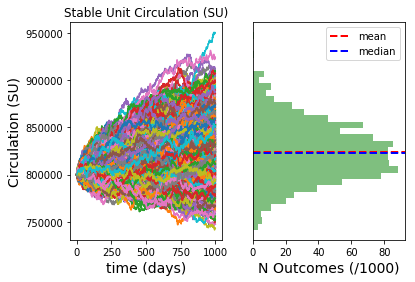

In [ ]:
# Simulation Paramters.
FLAGS_total_trials = 1000
FLAGS_total_steps = 1000
FLAGS_print_step = False

FLAGS_delta_t = 1.0
FLAGS_btc_price_drift = 0.0
FLAGS_btc_price_volatility = 0.001
FLAGS_su_demand_drift = 0.0
FLAGS_su_demand_volatility = 0.001

FLAGS_initial_reserve_ratio = 1.0
FLAGS_target_reserve_ratio = 1.0
FLAGS_initial_btc_reserve = 100
FLAGS_initial_btc_price = 8000

FLAGS_lowest_ask = 1.01
FLAGS_highest_bid = 0.99
FLAGS_do_rebase = True

params = Params()
print ("Experiment Params: " + params.__str__())
results = run_experiment(params)

plot_reserve_ratio(results)
plot_circulation(results)
plot_su_cum_demand(results)
plot_bitcoin_price(results)